In [1]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass
from typing import Callable
import numpy.typing as npt

from pathlib import Path
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from paper_code.altorithm import gamma_for_budget
from paper_code.multicommodity_flow.process_graph import read_graph, read_traffic, solve_problem_with_flow
from paper_code.multicommodity_flow.graph_functions import GraphFunc
from paper_code.utils.drawer import get_fig_set_style, save_figures


np.random.seed(0)

In [2]:
from copy import deepcopy

p = Path('./datasets/germany50')

gr = read_graph(p)
b_max = gr['bandwidth']

# m -- number of scenarios
# n -- the dimension of the optimization space
m = 10
n = len(b_max)

# for the experiment, we determine the cost of a unit 
# of flow at the beginning of the period c_a and during the period c_b
    
gr['cost'] /= 100
cost = gr['cost']  ##cost of servicing a unit of flow / base cost to generate c_a and c_b

# c_b
begin_cost = ((1/cost)**0.5) * 1000 * (0.9 + np.random.rand(n) * 0.2)
# c_a
additional_cost = begin_cost * (1.05 + np.random.rand(n) * 0.1)

The costs generated based on costs of bandwidths. Based on them, the initial *rental* cost and the cost of *rent* within the period were generated. If the bandwidth is cheaper, then it is a better bandwidth, so the cost of such a bandwidth should be higher. We also consider renting more expensive than maintenance. Therefore, the values at the beginning of the period were generated as $(c_b)_i = (1/bandwidth_{cost})^{0.5} * 10 \xi$, where $\xi \sim U[9, 11]$. The rental price during the period is considered higher: $(c_a)_i = (c_b)_i * \xi, \sim U[1.05, 1.15]$, that is, more expensive from 5 to 15%.

In the cell below, we initialize functions for different scenarios. 
To do this, the traffic matrix `traffic_matrix` is read for each scenario and thinned out. Next, `b_i` is initialized -- the bandwidth purchased at the beginning of the period. Next, the function calculates how much the system cost for the entire period `v` and how much additional bandwidth had to be rented by `extra_bw`.

All information is stored in the `result_handler`

In [3]:

@dataclass
class result_handler:
    function: Callable
    x: npt.NDArray
    extra_x: npt.NDArray
    value: float

results = []
verbose = True
for i in range(m):
    # correspondence matrix - what distinguishes different functions
    # after reading we do some thinning to make the task feasible
    traffic_mat = read_traffic(p / "tunnel_data" / f"Tunnel{i}.csv")
    scenario_fraction = 0.4
    traffic_mat = 4 * (np.random.rand(*traffic_mat.shape) > scenario_fraction) * traffic_mat 
    f = GraphFunc(gr['graph'], gr['cost'], traffic_mat, additional_cost)
    
    b_i = b_max * 4 * (np.random.rand(n)* 0.4 + 0.6)
    v = f(b_i, solver = cp.OSQP)
    
    extra_bw = f.rez['extra_bandwidth'] 
    tmp_res = result_handler(function = f,
                             x = b_i,
                             extra_x=extra_bw,
                             value= v)
    results.append(tmp_res)
    if verbose:
        st = "flow cost: {}\nbandwidth cost: {}\nextra bw cost: {}".format(
            v - additional_cost@ extra_bw,
            begin_cost@ b_i,
            additional_cost @ extra_bw
        )
        print(st)


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 1.4339521889171838
bandwidth cost: 3.760352043108778
extra bw cost: 3.558342198257723


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 1.1304626117090035
bandwidth cost: 3.812911770935698
extra bw cost: 2.2388183742226833
flow cost: 1.3521005920709759
bandwidth cost: 3.70197387269598
extra bw cost: 3.3131591517153427


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 1.27102993283173
bandwidth cost: 3.696793261419004
extra bw cost: 2.996039298992114
flow cost: 0.9185903303473275
bandwidth cost: 3.767118860860255
extra bw cost: 1.4213729619856943
flow cost: 1.2487757695082422
bandwidth cost: 3.7461673506173376
extra bw cost: 2.837423414586288
flow cost: 1.1288600548066583
bandwidth cost: 3.74629168829692
extra bw cost: 2.380373700129933
flow cost: 1.1359421100166682
bandwidth cost: 3.7532558654489363
extra bw cost: 2.4721742667300526


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 1.1865712249718245
bandwidth cost: 3.7472335512973376
extra bw cost: 2.5661929989479146
flow cost: 1.1249737583936033
bandwidth cost: 3.6839946063976368
extra bw cost: 2.501279422765925


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [4]:
def test_point(x):
    """
    to compute function values in founded points
    """
    res = []
    for r in results:
        f = r.function
        v = f(x, solver = cp.OSQP, max_iter = 30000)
        res.append(v)
    return np.array(res)

Compute values for different budgets and norms. Budgets selected as 
```
b = np.mean(budgets_used)
budgets = np.linspace(0.1 * b, 1.6 * b, 10)
```

In [5]:
from joblib import Parallel, delayed
@dataclass
class budget_result_handler:
    budget: float
    x: npt.NDArray
    gamma: float
    values: list[float]
    ratios: list[float] = None

def clip_func(x,y):
    """
    default function for clip, 
    which does not take into account monotonicity
    """
    return cp.maximum(y - x, 0)


x_s = np.stack([r.x for r in results], axis = 0)
v_s = np.array([r.value for r in results])
L_s = np.array([1 for _ in results]) # we use perturbed values
clip_functions = [clip_func for _ in v_s]


budgets_used = x_s @ begin_cost
b = np.mean(budgets_used)
budgets = np.linspace(0.1 * b, 1.6 * b, 10)



def get_b(b, norm = 1):
    x, gamma = gamma_for_budget(b, begin_cost, x_s, v_s, L_s,
                                clip_functions, norm= norm, 
                                verbose = False, hint=True)
    values = test_point(x)
    tmp_res = budget_result_handler(
        budget=b,
        x = x,
        gamma=gamma,
        values= values,
        )
    return tmp_res

del_get_b = delayed(get_b)

budget_norm_res = dict()
for norm in [1,2, "inf"]:
    budget_res = Parallel(n_jobs= 7)(del_get_b(b, norm) for b in budgets)            
    budget_norm_res[norm] = budget_res


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


plot results

In [11]:
values = np.array([(r.x @ begin_cost + r.value) for r in results])
ratios = np.array([(np.mean((r.x @ begin_cost + r.values)/values), np.std(r.values/values)) for r in budget_res]).T
gammas = [r.gamma for r in budget_res]
# values, ratios, gammas
values = np.array([(r.value) for r in results])
ratios = np.array([(np.mean((r.values)/values), np.std(r.values/values)) for r in budget_res]).T
gammas = [1 + r.gamma for r in budget_res]
# values, ratios, gammas

1 <class 'list'>
(2, 10)
2 <class 'list'>
(2, 10)
inf <class 'list'>
(2, 10)


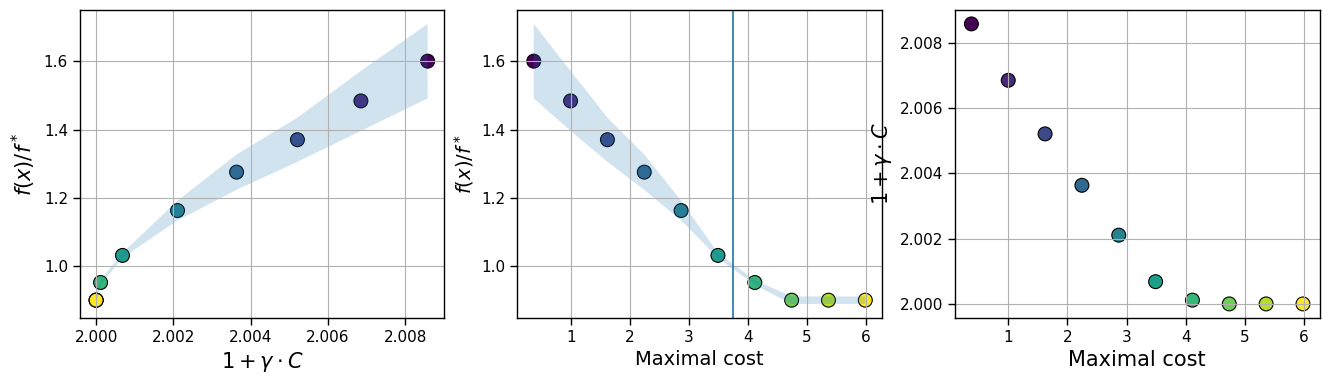

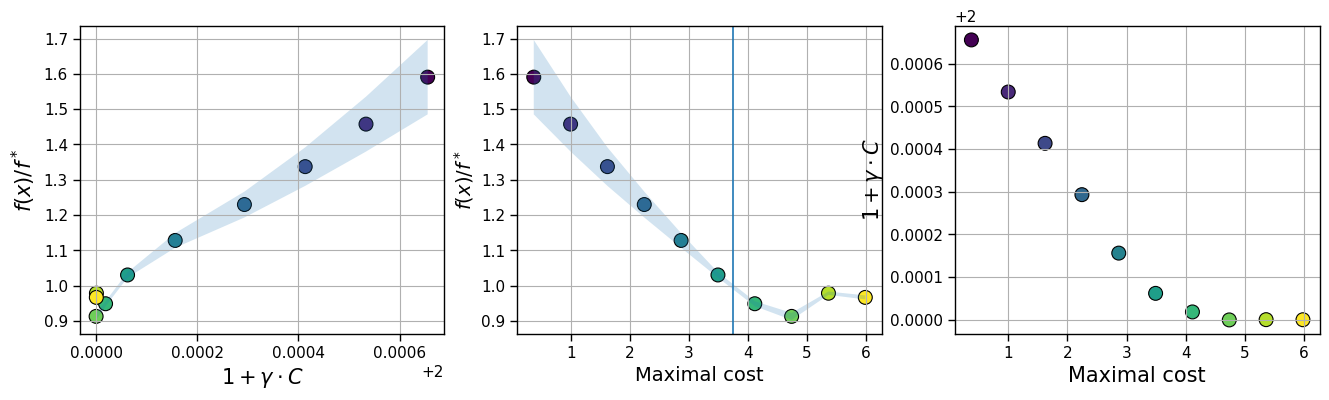

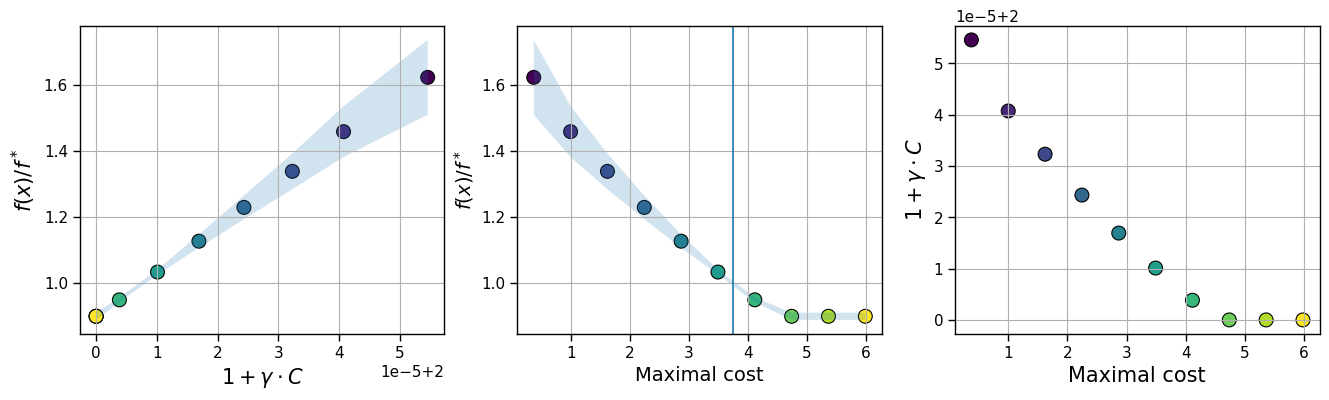

In [12]:
from paper_code.utils.drawer import plot_ratios

exp_ratios = []
for k, v in budget_norm_res.items():
    print(k, type(v))
    budget_res = v
    values = np.array([(r.value) for r in results])
    ratios = np.array([(r.values/values, r.values/values) for r in budget_res]).T
    exp_ratios.append(ratios)
    ratios = np.array([ratios[:,0].mean(0), ratios[:,1].std(0)])
    print(ratios.shape)
    gammas = [1 + r.gamma for r in budget_res]

    x1 = "Maximal cost"
    y1 = r"$f(x)/f^*$"
    l1 = r"$1 + \gamma \cdot C$"
    fig, ax = plot_ratios(ratios, gammas, budgets, x1,y1,l1, ratios_procecced=True)
    ax[1].axvline(x=np.mean(budgets_used))

exp_ratios = np.array(exp_ratios)[:,:,0]

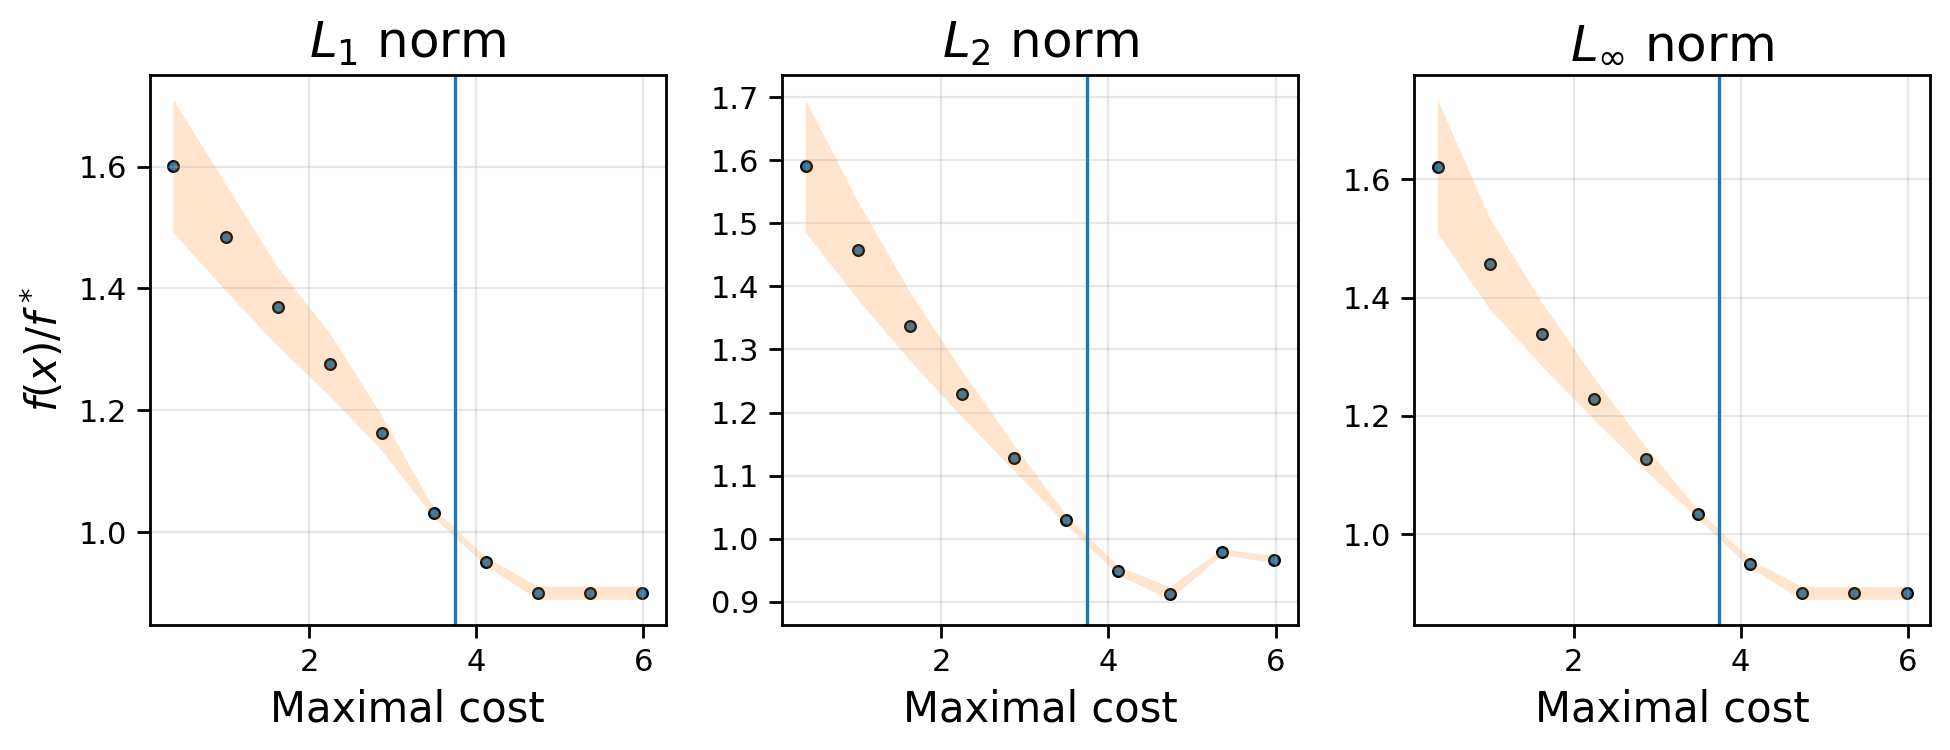

In [13]:
fig, ax = get_fig_set_style((1,3), (10,4))
names = [r"$L_1$ norm",r"$L_2$ norm",r"$L_\infty$ norm"]
for i, res in enumerate(exp_ratios):
    ratios = res.T
    ratios_stat = np.array([(np.mean(r), np.std(r)) for r in ratios]).T
    # colors = np.linspace(0, 2., len(ratios_stat[0]))

    ax[i].scatter(budgets , ratios_stat[0], ec = 'k', s = 15)
    ax[i].fill_between(budgets , ratios_stat[0] - ratios_stat[1], ratios_stat[0] + ratios_stat[1], alpha = 0.2)
    ax[i].grid(which="major", alpha=0.3)
    ax[i].set_title(names[i])
    ax[i].set_xlabel(x1)
    ax[i].ticklabel_format(axis="x", scilimits=[-3, 3])
    ax[i].axvline(x=np.mean(budgets_used))
ax[0].set_ylabel(y1)
plt.tight_layout()
plt.show()

images = {"triple_mcf": fig}

Hint:
in the monotonous case, we add a penalty to the budget used, then when "saturation" is reached, the corners intersect without penalty, the minimum possible budget is used.

(10, 10)


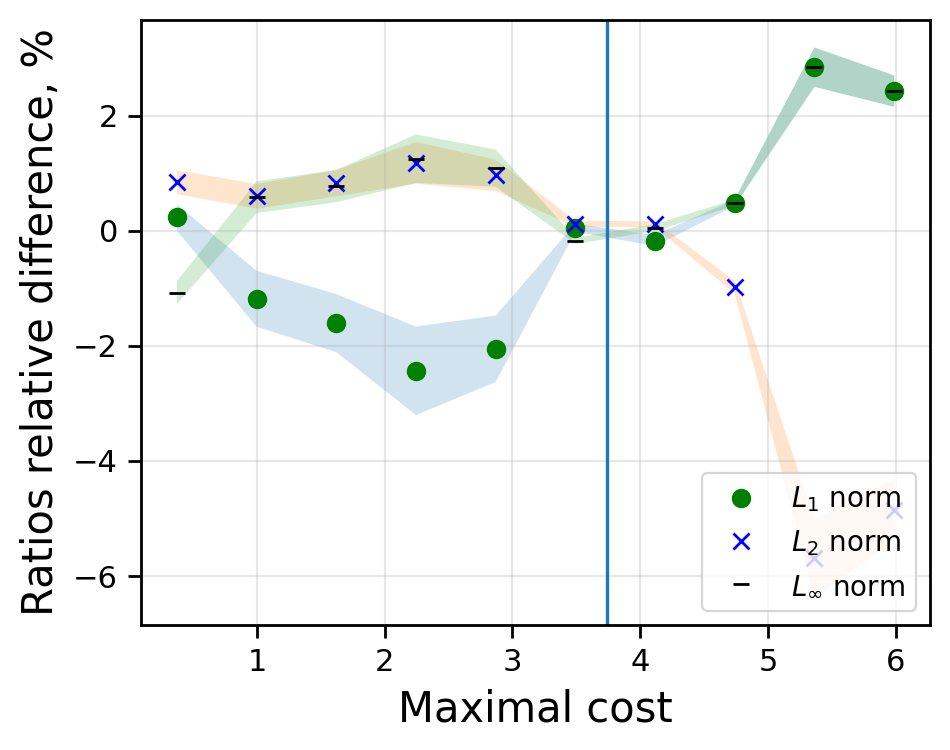

In [14]:
mmean = exp_ratios.mean(0)
print(mmean.shape)
colors = [ 'green', "blue", 'black']
styles = ['o', 'x', '_']
names = [r"$L_1$ norm",r"$L_2$ norm",r"$L_\infty$ norm"]
fig, ax = get_fig_set_style((1,1), (5,4))
# plt.figure(figsize = (5,4), dpi = 200)
ax.axvline(x=np.mean(budgets_used))
for i, r in enumerate(exp_ratios):
    ratios = r
    ratios_diff = ((mmean - ratios)/(mmean)).T
    ratios__diff_stat = np.array([(np.mean(r), np.std(r)) for r in ratios_diff]).T * 100
    # colors =  np.linspace(0, 2., len(max_budgets))
    # plt.scatter(max_budgets, (ratios_diff).mean(1), c = colors, ec = 'k')
    # ax[i].scatter(budgets , ratios_stat[0], ec = 'k', s = 15)
    ax.plot(budgets, ratios__diff_stat[0], styles[i], \
                color = colors[i], label = f"{names[i]}",
                markersize = 6)
    ax.fill_between(budgets, ratios__diff_stat[0] - ratios__diff_stat[1], 
                    ratios__diff_stat[0] + ratios__diff_stat[1], alpha = 0.2)
ax.ticklabel_format(axis="x", scilimits=[-3, 3])
ax.grid(which="major", alpha=0.3)
ax.legend(loc="lower right")
ax.set_ylabel("Ratios relative difference, %", fontsize = 15)
ax.set_xlabel(x1, fontsize = 15)
plt.tight_layout()
plt.show()

images["relative_mcf"] = fig

In [15]:
save_figures(images, Path("./figures"))